 # Lecture7 : MCMC under the Hood 
 
 ## Instructor: Dr. Hu Chuan-Peng 

## Normal-Normal 模型的后验分布

1. 假设我们从一个平均值为$\mu$，标准差为0.75的正态分布中抽出了一个Y=6.25的数值

    我们可以将**似然函数**写为：

    $$
    Y|\mu  \sim \ N(\mu, 0.75^2)
    $$

2. 并且，该正态分布群的平均值满足：

    **先验分布**可以写成
    $$
    \mu  \sim \ N(0, 1^2)
    $$

    *可以简单理解成我们一开始对$\mu$的信念，为$\mu$在平均值为0，标准差为1的正态分布中波动*


3. 那么$Y=6.25$这个结果，更可能在哪种正态分布之下出现：

    **后验分布**：结合了先验和似然，完成了对$\mu$信念的更新

    $$\mu | (Y = 6.25) \sim \text{N}(?,?)$$

> 在lec5中，我们知道Normal-Normal为共轭先验，则后验有直接的计算方法，事实上，后验分布为：

> $$\mu | (Y = 6.25) \sim \text{N}(4, 0.6^2)$$


**使用MCMC来近似 Normal-Normal 模型的后验分布**

从lec6中我们知道，有些时候我们无法直接计算后验分布，可以使用MCMC对后验进行近似

假设我们使用MCMC进行了 N=5000次 的采样，那么我们可以得到这样一条马尔科夫链 $\left\lbrace \mu^{(1)}, \mu^{(2)}, \ldots, \mu^{(N)} \right\rbrace$

* 左图展示了每一次采样的结果，而通过右图我们可以知道采样结果的分布如何（即哪些值出现的频率更高）

![Image Name](https://www.bayesrulesbook.com/bookdown_files/figure-html/ch-7-mcmc-goal-1.png)


❓那么这些采样值是怎么得到的？

> 我们以这个Normal-Normal 模型为例，来详细介绍采样的规则


**未归一化的后验分布(unnormalized posterior pdf)**

在介绍采样算法的具体细节之前，我们来对采样建立一些直觉上的理解：

下图为真实的后验分布，可以看到，在后验分布中，$\mu$的结果主要集中在 2-6 之间，那么我们希望：

* 采样主要在2-6这个范围内进行
* 采样值出现的频率要和其对应的后验概率一致(比如4出现的频率高于3出现的频率)

> ❓但是真正采样的时候，我们无法获得后验概率，那要怎么知道哪些值应该经常出现

当分母太过复杂时，我们确实无法计算后验分布，但通过贝叶斯公式我们知道：

$$f(\mu | y=6.25) \propto f(\mu)L(\mu|y=6.25).$$

尽管未归一化的分布并不是真正的后验分布，但这二者的形状、集中趋势、变异性是一样的

![Image Name](https://cdn.kesci.com/upload/s2ty9jty8t.png?imageView2/0/w/960/h/960)

因此，未归一化的后验分布可以为我们的采样提供参照

## Metropolis-Hastings(MH)算法

### MH算法的第一步：建议分布(proposed distribution)

在lec6中，我们提到马尔科夫链上有不同的状态，而状态之间转移的概率是一定的。

我们将类似的思想用在采样中，可以简单理解为，每个采样值都可以是马尔科夫链上的一个状态。抽样的结果就是一个有序的马尔科夫链

>*为配合轨迹图进行说明，我们将状态间的转移称为**位置**上的转移*

假设我们的起始位置为3，那么接下来又出现了新的问题：怎么知道下一个位置是什么，即采样的样本从何而来？

在这里我们介绍**MH算法的第一步**

1. 为了求解一个不常见的分布$p(x)$，先构造一个常见的分布$q(x)$进行采样，其中$q(x)$叫做建议分布(proposal distribution)

    * 我们使用均匀分布作为建议分布

    * 假设当前的位置为$\mu$，再指定均匀分布一半的宽度为$w$，则可产生均匀分布$\text{Unif}(\mu - w, \mu + w)$

    * 下一个采样值$\mu'$就是从这个均匀分布中被提出的
    
    $$\mu' | \mu \; \sim \; \text{Unif}(\mu - w, \mu + w)$$

    其pdf为：
    $$q(\mu'|\mu) = \frac{1}{2w} \;\; \text{ for } \;\; \mu' \in [\mu - w, \mu + w] $$


![Image Name](https://www.bayesrulesbook.com/bookdown_files/figure-html/ch7-unif-1.png)

-------

在这个Normal-Normal 模型例子中，我们当前的位置是3，假设均匀分布一半的宽度$w=1$，则建议均匀分布表示为：$Unif(3-1, 3+1) = Unif(2, 4)$，所以下一个值我们会在2-4中选

![Image Name](https://www.bayesrulesbook.com/bookdown_files/figure-html/ch-7-mh-proposal-1.png)


我们从这个均匀分布中选择下一个采样值，但我们还需要决定，我们是要拒绝这个选择，还是接受这个选择

> 🤔你觉得, 采样值$\mu'=2.1$被接受的可能性高，还是采样值$\mu'=3.8$被接受的可能性高？


### MH算法的第二步：直觉理解

![Image Name](https://cdn.kesci.com/upload/s2tvmqle0b.png?imageView2/0/w/960/h/960)

> 假设我们从$Unif(2,4)$中抽出了3.8这个值，在未经标准化的后验分布中，3.8对应的可能性高于3。
> * 因此，我们可以接受这个值，并且希望接下来马尔科夫链可以多在这附近探索。

> 但如果我们抽出的值为2.1，我们则会犹豫要不要接受这个值

------------------------

在详细介绍算法的规则之前，我们还是先来建立一些直觉上的理解：

* 考虑接受建议的三种情况：

    1：始终不接受提议。

    2：始终接受提议。

    3：只有当提议的后验可能性大于当前值的后验可能性时，才接受提议

* 我们来看看这三种情况对应生成的trace plot
![Image Name](https://www.bayesrulesbook.com/bookdown_files/figure-html/ch7-bad-step2-1.png)

    1. 使得马尔科夫链在采样时一直停在同一个值

    2. 马尔科夫链的采样并不会稳定在某一个范围内
    
    3. 采样只停留在$\mu = 4$附近(只能采到一部分值)

* 因此我们知道，尽管采样应该更多地停留在“高后验可能性的值”，但也不能只取到这附近的值。


**暂时总结**

对于Metropolis-Hastings算法：

1. 基于当前的提议模型，提议下一个采样值$\mu'$

2. 决定是否接受下一个采样值($\mu^{(i+1)} = \mu'$)，还是拒绝下一个采样值，停留在当前位置($\mu^{(i+1)} = \mu$)

    * 如果下一个值$\mu'$对应的后验可能性高于当前值$\mu$对应的后验可能性，$f(\mu')L(\mu'|y) > f(\mu)L(\mu|y)$，**则接受这个值**

    * 否则，我们**或许可以接受**这个值

> ❓所以，如果下一个采样值的后验可能性比当前位置对应的后验可能性更低，我们怎么来决定是否要接受这个值呢？

**接受概率$\alpha$**

在当前位置$\mu$的基础上，从建议模型中抽取$\mu'$，该概率可以写为$q(\mu'|\mu)$

对于是否接受$\mu'$，我们定义接受概率$\alpha$

$$
  \alpha = \min\left\lbrace 1, \; \frac{f(\mu')L(\mu'|y)}{f(\mu)L(\mu|y)} \frac{q(\mu|\mu')}{q(\mu'|\mu)} \right\rbrace.
$$


在均匀分布中:

$$q(\mu'|\mu) = q(\mu|\mu')$$

因此公式可以简写为：
$$
\alpha = \min\left\lbrace 1, \; \frac{f(\mu')L(\mu'|y)}{f(\mu)L(\mu|y)} \right\rbrace  
$$

> 注：当建议分布是对称的时候(比如此时的均匀分布)，这是Metropolis-Hastings算法中的一种特例。

对于接受或拒绝$\mu'$，则有：
$$
\mu^{(i+1)} = 
 \begin{cases}
 \mu' &  \text{ with probability } \alpha \\
 \mu &  \text{ with probability } 1- \alpha. \\
 \end{cases}
 $$



**进一步解释接受概率$\alpha$**

我们可以也可以把$\alpha$写成这种形式：
$$
\alpha = \min\left\lbrace 1, \; \frac{f(\mu')L(\mu'|y) / f(y)}{f(\mu)L(\mu|y) / f(y)} \right\rbrace = \min\left\lbrace 1, \; \frac{f(\mu'|y)}{f(\mu|y)} \right\rbrace  .
$$

完全可以将$\alpha$视为真实后验概率的比值($f(\mu'|y)$与$f(\mu|y)$)

我们考虑 $f(\mu'|y)$ / $f(\mu|y)$会出现的两种可能情况

1. $f(\mu'|y) \ge f(\mu|y)$
* 当$\mu'$的后验概率大于$\mu$的后验概率，此时$\alpha=1$，那么接受$\mu'$

2. $f(\mu'|y) < f(\mu|y)$
* 当$\mu'$的后验概率小于$\mu$的后验概率，此时$\alpha = \frac{f(\mu'|y)}{f(\mu|y)} < 1  .$，
* 有$\alpha$的可能性接受$\mu'$，当$\alpha$越趋近于1，接受$\mu'$的可能性也就越高

### 代码示例

我们使用代码感受一下这个过程

In [55]:
import numpy as np
import scipy.stats as st
import pandas as pd
import seaborn as sns

In [56]:
np.random.seed(8)

current = 3                                            # 设定当前位置为3

proposal = np.random.uniform(current-1, current+1)     # 从均匀分布(2,4)中抽出一个样本

print(proposal)

3.7468588055836323


In [57]:
# 计算建议位置的未归一化的后验概率值（先验*似然）
proposal_plaus = st.norm.pdf(proposal, loc = 0, scale = 1) * st.norm.pdf(6.25, loc = proposal, scale = 0.75)

# 计算当前位置的未归一化的后验概率值（先验*似然）
current_plaus = st.norm.pdf(current, loc = 0, scale = 1) * st.norm.pdf(6.25, loc = current, scale = 0.75)

# 计算接受概率α，为两者概率值之比
alpha = min(1,proposal_plaus/current_plaus)

# 打印出接受概率α
print("alpha:", alpha)

alpha: 1


In [58]:
# 根据接受概率α进行抽样，抽样内容为建议位置和当前位置
next_stop = np.random.choice([proposal, current], 1, p=[alpha,1-alpha])

# 打印出下一个位置的值
next_stop[0]

#从第一段代码我们可以看到此时的接受概率α=1，因此接受了建议值作为我们的下一个值

3.7468588055836323

**定义单次采样函数**

我们可以直接定义一个函数，将刚刚的操作全都结合在一起，这样当我们想进行抽样的时候，不用重复写代码

In [59]:
def one_mh_iteration(w,current):

    """
    def后面为函数值，(w,current)为两个接受的输入值，我们需要指定均匀分布的一半宽度和当前位置
    
    接下来的代码和之前一样

    return 则是该函数返回的值，我们将建议值，接受概率，和下一个位置这三个值组成了一个数据框进行返回
    """
    proposal = np.random.uniform(current-w, current+w)

    proposal_plaus = st.norm.pdf(proposal, loc = 0, scale = 1) * st.norm.pdf(6.25, loc = proposal, scale = 0.75)
    current_plaus = st.norm.pdf(current, loc = 0, scale = 1) * st.norm.pdf(6.25, loc = current, scale = 0.75)
    alpha = min(1,proposal_plaus/current_plaus)
    next_stop = np.random.choice([proposal, current], 1, p=[alpha,1-alpha])
    return pd.DataFrame({"proposal":[proposal],
                         "alpha":[alpha], 
                         "next_stop":[next_stop[0]]})
np.random.seed(8)
one_mh_iteration(w=1,current=3)

,proposal,alpha,next_stop
0,3.746859,1,3.746859


In [60]:
# 变换不同的随机数种子，其实也是生成不同的建议值
np.random.seed(83)
one_mh_iteration(w=1,current=3)

,proposal,alpha,next_stop
0,2.514085,0.186803,3.0


**多次采样**

上述函数只进行了一次采样，即当前位置为3时，下一个可能采样的结果

基于当前位置，提出下一个采样值，接受或拒绝它。那么新的采样值就变成了当前位置，我们需要不断重复这个过程

In [61]:
def mh_tour(N,w):

    """
    N为迭代次数，w为均匀分布的一半宽度

    我们在单次采样函数的基础上叠加了一个循环
    将每次的采样结果存在mu[i]中，
    在每次采样结束后，将采样结果替换为当前位置

    返回值为迭代次数，和每次采样得到的结果
    """
    current = 3
    mu = np.zeros(N)

    for i in range(N):
        sim = one_mh_iteration(w=w, current=current)
        mu[i] = sim["next_stop"][0]
        current = sim["next_stop"][0]
    
    return pd.DataFrame({"iteration": range(1,N+1),
                         'mu': mu})

In [62]:
# 调用定义好的函数，将采样次数设为5000，均匀分布的一半宽度设为1
np.random.seed(84735)
mh_simulation = mh_tour(N=5000, w=1)

**采样结果图示**

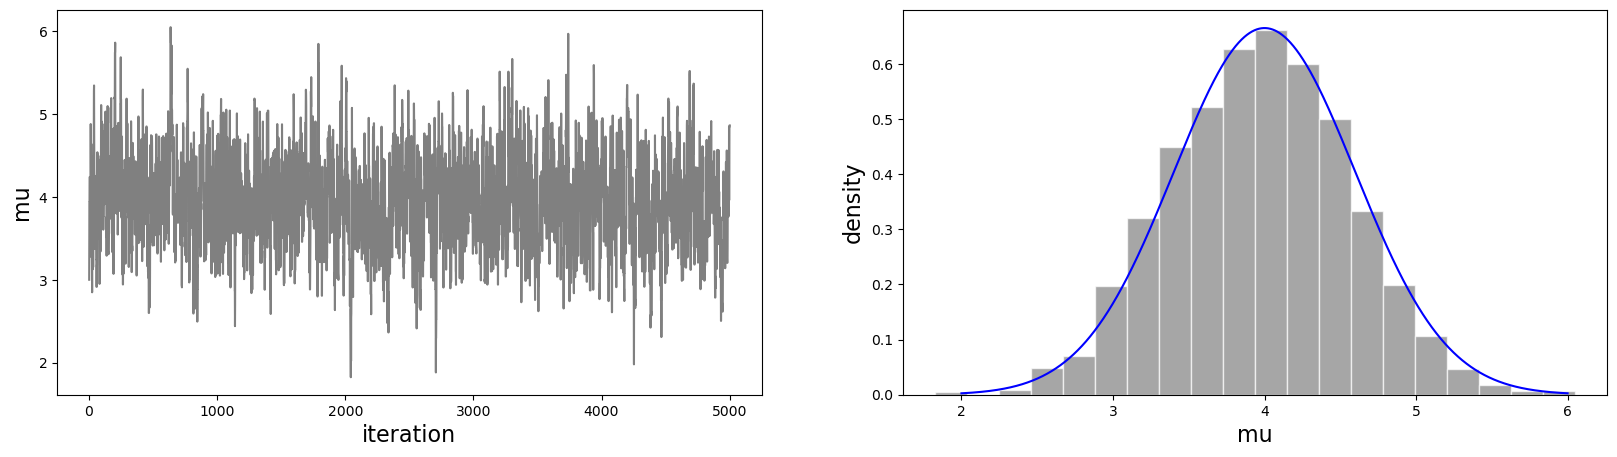

In [71]:
import matplotlib.pyplot as plt

#生成一行两列的画布
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

#trace plot：在第一列绘制出每一次的采样结果
axs[0].plot(mh_simulation["iteration"], mh_simulation["mu"],
            color="grey",)
axs[0].set_xlabel("iteration", fontsize=16)
axs[0].set_ylabel("mu", fontsize=16)

#density plot：在第二列绘制出采样结果的分布
axs[1].hist(mh_simulation["mu"], 
            edgecolor = "white",
            color="grey",
            alpha = 0.7,
            bins = 20,
            density = True)
axs[1].set_xlabel("mu", fontsize=16)
axs[1].set_ylabel("density", fontsize=16)

# 绘制真实的后验分布 N(4,0.6)
x_norm = np.linspace(2,6,10000)                   # 生成一个 10000 个点，范围在 [0, 15] 之间
y_norm = st.norm.pdf(x_norm, loc=4, scale=0.6)    # 生成Gamma(13,3)下, x对应的概率值

axs[1].plot(x_norm, y_norm, color='blue')


### 调试(Tuning)Metropolis-Hastings 算法

在建议分布 $\mu' | \mu \; \sim \; \text{Unif}(\mu - w, \mu + w)$中，$w$反映了 建议选项的分布宽度，对$w$的选择也会影响马尔科夫链的表现

🧐思考：我们仍然使用MH算法，建议分布为$Unif(\mu - w, \mu + w)$，现在有三种$w$
* $w = 0.01$
* $w = 1$
* $w = 100$
    
请你判断以下的轨迹图和密度图分别对应上述哪种情况

![Image Name](https://www.bayesrulesbook.com/bookdown_files/figure-html/ch7-bad-idea-1.png)


可以结合以下代码进行判断

In [ ]:
#===========================================================================
#                            请修改 ... 中的值。
#===========================================================================
np.random.seed(84735)

mh_simulation = mh_tour(N=5000, w= ...)

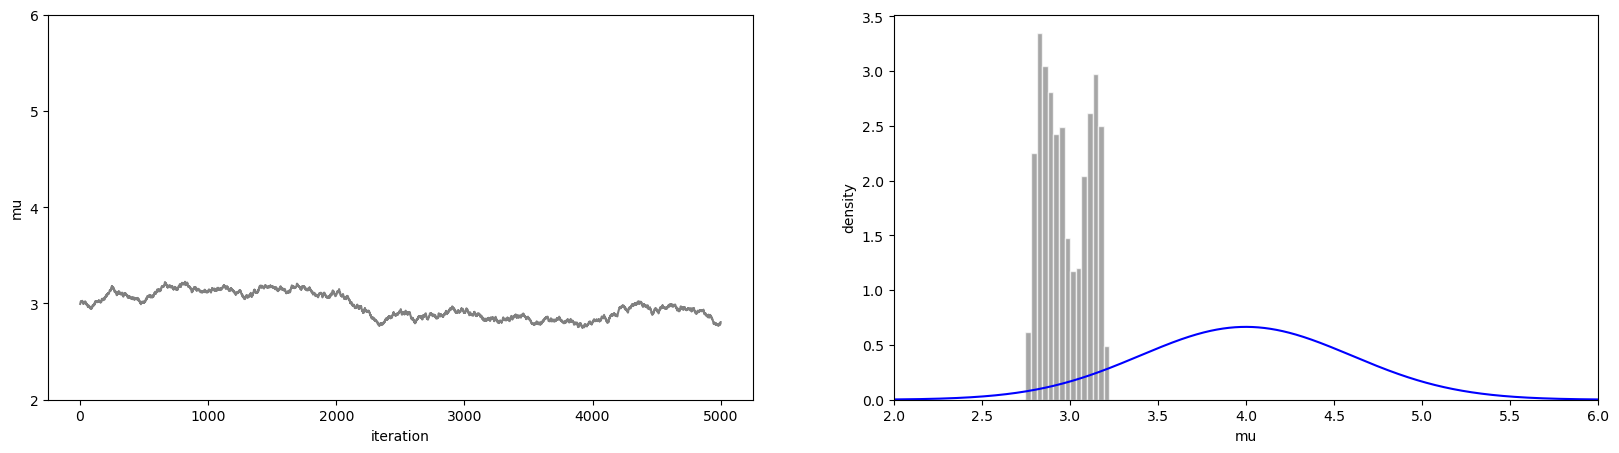

In [ ]:
#绘图
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
#===========================================================================
axs[0].plot(mh_simulation["iteration"], mh_simulation["mu"],
            color="grey",)
axs[0].set_yticks(np.arange(2,7,1))
axs[0].set_xlabel("iteration", fontsize=16)
axs[0].set_ylabel("mu", fontsize=16)
#===========================================================================
axs[1].hist(mh_simulation["mu"], 
            edgecolor = "white",
            color="grey",
            alpha = 0.7,
            bins = 15,
            density = True)
axs[1].set_xlim([2,6])
axs[1].set_xlabel("mu", fontsize=16)
axs[1].set_ylabel("density", fontsize=16)
#===========================================================================
x_norm = np.linspace(2,6,10000)                  
y_norm = st.norm.pdf(x_norm, loc=4, scale=0.6)    
axs[1].plot(x_norm, y_norm, color='blue')

**总结**

* 当$w = 0.01$时：

    建议分布的范围很窄，比如$Unif(2.99, 3.01)$，这会导致下一个建议值和当前值非常接近，则$f(\mu')L(\mu'|y) \approx f(\mu)L(\mu|y)$
    $$
    \alpha = \min\left\lbrace 1, \; \frac{f(\mu')L(\mu'|y)}{f(\mu)L(\mu|y)} \right\rbrace \approx \min\left\lbrace 1, \; 1 \right\rbrace \; = 1 .
    $$
    那么我们很容易接受下一个采样值，但尽管马尔科夫链一直在转移，但探索的范围太窄了，我们可以看到采样一直在3附近

* 当$w = 100$时：

    类似的，我们可以推知此时建议分布的范围太宽了，超出了$\mu$可能的取值

    下一个建议值和当前值间隔太远，这会导致我们经常拒绝下一个采样值，多次停在当前位置。